Import libraries

In [376]:
import numpy as np
import pennylane as qml
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from pennylane import numpy as pnp

import jax
import jax.numpy as jnp
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from pennylane_qiskit import AerDevice
from pennylane_ionq import ops
from qiskit_aer import AerSimulator


jax.config.update("jax_enable_x64", True)

import optax


Circuit function layer thing

In [377]:
def strong_layer(parameters):
    #circuit = strong_layer(n_qubits, params, 6)
    #measurements = qml.from_qiskit(circuit)()
    param_index=0
    for i in range(6):
        for qubit in range(n_qubits):
            qml.RX(parameters[param_index], wires=qubit)
            param_index += 1
            qml.RY(parameters[param_index], wires=qubit)
            param_index += 1
            qml.RZ(parameters[param_index], wires=qubit)
            param_index += 1
        # Apply CNOT gates for entanglement
        for qubit in range(n_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])
        #for qubit in range(n_qubits):
        #    qml.BitFlip(0.05, wires=qubit)
    return qml.probs(wires=range(n_qubits))

Generate Bars and Stripes dataset

In [378]:
def get_bars_and_stripes(n):
    bitstrings = [list(np.binary_repr(i, n))[::-1] for i in range(2**n)]
    bitstrings = np.array(bitstrings, dtype=int)

    stripes = bitstrings.copy()
    stripes = np.repeat(stripes, n, 0)
    stripes = stripes.reshape(2**n, n * n)

    bars = bitstrings.copy()
    bars = bars.reshape(2**n * n, 1)
    bars = np.repeat(bars, n, 1)
    bars = bars.reshape(2**n, n * n)
    return np.vstack((stripes[0 : stripes.shape[0] - 1], bars[1 : bars.shape[0]]))


n = 3
size = n**2
n_qubits = size
data = get_bars_and_stripes(n)

bitstrings = []
nums = []
for d in data:
    bitstrings += ["".join(str(int(i)) for i in d)]
    nums += [int(bitstrings[-1], 2)]
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)



Define the device used

In [379]:


#dev = AerDevice(wires=n_qubits, backend='aer_simulator')
#dev = qml.device("ionq.simulator", wires=n_qubits, api_key="iRpYWZL97FtKxQRHyGZZU5lgbnhEwAZj")
dev = qml.device("default.qubit", wires=n_qubits)
#dev = qml.device("qiskit.aer", wires=n_qubits)


The choosing of the circuit

In [380]:
@qml.qnode(dev)
def circuit(parameters):
    return strong_layer(parameters)
jit_circuit = jax.jit(circuit)


Cost function

In [381]:
def costsquare(params):
    output_probs = jit_circuit(params)
    
    target_probs = probs
    cost_value = jnp.sum( jnp.square(target_probs-output_probs))
    return cost_value, target_probs

Optimize the quantum circuit

In [382]:
params = np.random.random(size=n_qubits*6*3+1)

opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(params)


@jax.jit
def update_step(params, opt_state):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(costsquare, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_val


history = []
n_iterations = 100

for i in range(n_iterations):
    params, opt_state, loss_val = update_step(params, opt_state)

    print(f"Step: {i} Loss: {loss_val:.4f}")

    history.append(loss_val)
print(params)
optimal_params=params
output_probs = circuit(optimal_params)



#print(optimal_params)
#print(output_probs)

Step: 0 Loss: 0.0649
Step: 1 Loss: 0.0582
Step: 2 Loss: 0.0530
Step: 3 Loss: 0.0501
Step: 4 Loss: 0.0478
Step: 5 Loss: 0.0459
Step: 6 Loss: 0.0443
Step: 7 Loss: 0.0428
Step: 8 Loss: 0.0420
Step: 9 Loss: 0.0413
Step: 10 Loss: 0.0406
Step: 11 Loss: 0.0402
Step: 12 Loss: 0.0396
Step: 13 Loss: 0.0392
Step: 14 Loss: 0.0385
Step: 15 Loss: 0.0377
Step: 16 Loss: 0.0370
Step: 17 Loss: 0.0360
Step: 18 Loss: 0.0345
Step: 19 Loss: 0.0332
Step: 20 Loss: 0.0322
Step: 21 Loss: 0.0312
Step: 22 Loss: 0.0304
Step: 23 Loss: 0.0298
Step: 24 Loss: 0.0294
Step: 25 Loss: 0.0294
Step: 26 Loss: 0.0297
Step: 27 Loss: 0.0298
Step: 28 Loss: 0.0296
Step: 29 Loss: 0.0292
Step: 30 Loss: 0.0287
Step: 31 Loss: 0.0280
Step: 32 Loss: 0.0275
Step: 33 Loss: 0.0269
Step: 34 Loss: 0.0263
Step: 35 Loss: 0.0258
Step: 36 Loss: 0.0252
Step: 37 Loss: 0.0246
Step: 38 Loss: 0.0241
Step: 39 Loss: 0.0238
Step: 40 Loss: 0.0234
Step: 41 Loss: 0.0232
Step: 42 Loss: 0.0229
Step: 43 Loss: 0.0225
Step: 44 Loss: 0.0222
Step: 45 Loss: 0.021

Plot histograms

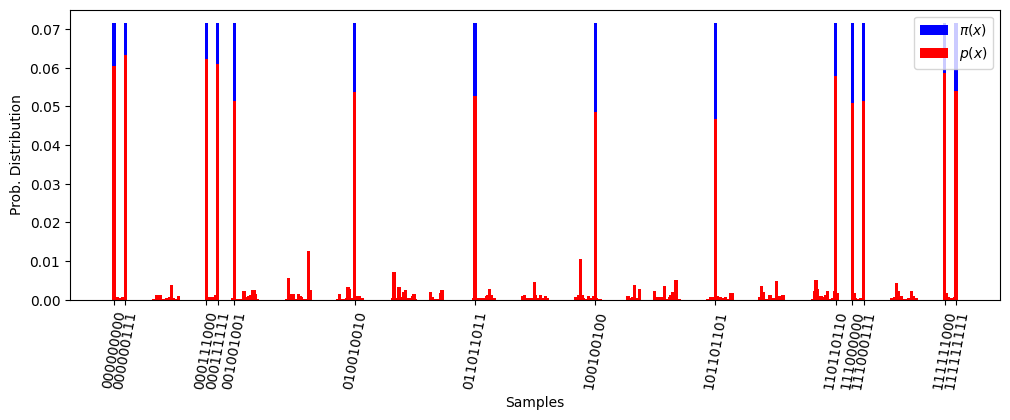

In [383]:
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**size), probs, width=2.0, label=r"$\pi(x)$", color='blue')
plt.bar(np.arange(2**size), output_probs, width=2.0, label=r"$p(x)$",color='red')

plt.xticks(nums, bitstrings, rotation=80)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

In [384]:
acr=0
for i in nums:
    acr+=output_probs[i]
print(acr)

0.7724239301111339


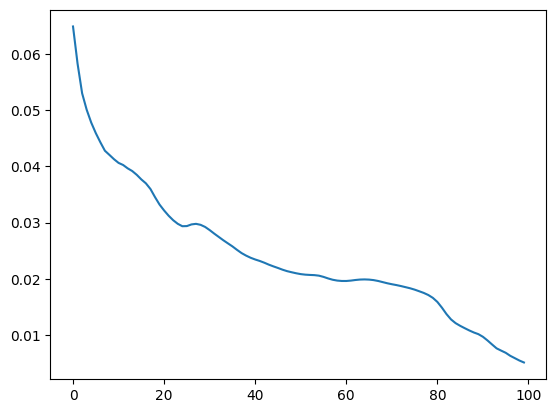

In [385]:
plt.plot(history)

plt.show()

In [386]:
print("[")
for i in params:
    print(i, ",")
print(")")

[
0.16157871822323985 ,
0.5194220762453746 ,
1.0886935253656544 ,
-0.6574618862715235 ,
0.7754873169803892 ,
0.7690528759943863 ,
0.6266668780951806 ,
1.265159970688073 ,
0.788437013403112 ,
0.5307469599458927 ,
0.4056750196670031 ,
0.7903085021510902 ,
1.0046279074979145 ,
0.6551114595708004 ,
0.5293690172594298 ,
-0.4654500074906342 ,
-0.6039238291951352 ,
-0.8692823861544396 ,
-0.30075193930026023 ,
0.013571226448511485 ,
0.5250674385980838 ,
0.4506889682975657 ,
1.2838743595945203 ,
-0.221736187671728 ,
0.6942533621806787 ,
1.0084388420994381 ,
0.5689099019070283 ,
0.5589618269339343 ,
0.6005966702976897 ,
0.21661375116804982 ,
0.3309147456874364 ,
0.7707095409956464 ,
1.1172762755448602 ,
1.6177046771464871 ,
1.8431796507738385 ,
1.4453701629906746 ,
0.5347234092734494 ,
0.45825800415268614 ,
0.46897840053364803 ,
-1.2123075513921504 ,
2.4537142711924433 ,
0.3294447464588884 ,
0.7826073799683257 ,
0.10292093760390916 ,
2.7694703046256115 ,
-0.040910288958551894 ,
1.694071412859178